# Beeldherkenning

_Notebook gemaakt door Emma Vriezen, De Vlinderstichting, 30 november 2023_

In dit Notebook wordt een model getraind om automatisch afbeeldingen te classificeren. Dit model heeft verschillende benamingen: een neuraal netwerk, een convolutional netwerk, AI, automatische beeldherkenning, etc. Waar het op neer komt is dat het model patronen in afbeeldingen leert herkennen, die bij een bepaalde klasse (= class(ification), label, soort, type...) horen. Hiervoor is een gelabelde dataset nodig. Van elke klasse die het model moet leren herkennen, zijn er foto's nodig; hoe meer, hoe beter. Als het model erin slaagt om de verschillende klasses uit elkaar te halen, dan zou het ook nieuwe foto's, zonder label, kunnen classificeren met de juiste label.

Voordat je met dit Notebook aan de slag gaat, moet de trainingsdata in deze structuur gezet worden:

```
├── Dataset
│   ├── Klasse A
│   │   ├── Foto 1
│   │   ├── Foto 2
│   │   ├── ...
│   │   └── Foto n
│   ├── Klasse B
│   │   ├── ...
│   │   └── Foto m
│   ├── Klasse C
│   ├── Klasse ...
│   └── Klasse Z
```

Oftewel: één hoofdfolder die subfolders bevat, en elke subfolder representeert één klasse. Elke subfolder bevat (symlinks naar) foto's van die klasse.

Verder moet het bestand `mothUtils.py` in dezelfde map staan als dit bestand.

## Environment check
Het onderstaande blok print het pad naar de huidige pythoninstallatie. Als je python hebt geïnstalleerd volgens de handleiding, zou de locatie 'miniconda3/envs/\[naam\]/bin/python' moeten zijn. Staat er iets anders? Pas dan de kernel van dit Notebook aan (Kernel ->  Change kernel -> \[naam\]). Staat jouw environment er niet tussen? Dan is hij niet geïnstalleerd als kernel. Kijk nogmaals naar de handleiding ('Installeer jupyter in den nieuwe environment').


In [1]:
import sys
sys.executable


'/home/farfalla/miniconda3/envs/ml/bin/python'

## GPU check
Het trainen van een neuraal netwerk gaat het snelst op een GPU. Als de output van het volgende blok `True` is, dan wordt een GPU gebruikt. Als het `False` is, dan ofwel heeft de huidige computer geen (bruikbare) GPU, of de geïnstalleerde CUDA versie pas niet bij de GPU. Meer info in de handleiding voor de installatie.

In [2]:
import torch
torch.cuda.is_available()


True

## Overige imports

In [3]:
# General
import csv
import numpy as np
import time
from datetime import datetime

# Data
from pathlib import Path
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from mothUtils import FilteredImageFolder

# Model
from torchvision.models import get_model

# Visualisation
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Evaluation
from sklearn.metrics import precision_score, recall_score, classification_report


In [4]:
# Use the GPU if available, else pick CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')


Device: cuda:0


## Instellingen

Pas deze variabelen zo nodig aan voor de situatie.

- **seed**: Dit controleert de random state; dezelfde seed leidt tot reproduceerbare uitkomsten van het model. Kies een leuk getal of laat het staan zoals het is.
- **data_path**: Pad naar de folder met de dataset.
- **min_samples**: Minimaal aantal foto's per klasse. Als een klasse minder foto's heeft, dan wordt het op één hoop gegooid met andere kleine klasses onder de noemer 'Overig'. Zet op `1` om klasses nooit samen te voegen.
- **other_class_weight**: Hoe belangrijk de klasse 'Overig' is. Tussen 0 en 1, standaard 0.5. Heeft alleen effect als min_samples > 1.
- **val_fraction**: Deel van de dataset die als validatie gebruikt moet worden. Tussen 0 en 1, standaard 0.1.
- **test_fraction**: Deel van de dataset die als test gebruikt moet worden. Tussen 0 en 1, standaard 0.1.
- **batch_size**: Aantal foto's die tegelijkertijd aan het model gevoerd worden tijdens een trainingsstap. Hoe hoger, hoe sneller het trainen gaat, maar hoe meer geheugen er gebruikt wordt. Als er een OOM (= out of memory) error is, verlaag batch_size. Tussen 1 en 256 (of hoger, maar dit is een goede maximum), standaard 32.
- **num_workers**: Pas dit aan om de trainingstijd te beïnvloeden. Optimale waarde hangt af van de opstelling van de computer en wordt gevonden met trial-and-error. Minimaal 1, standaard 4.
- **model_name**: Naam van het architectuur/het model dat verder getrained gaat worden op de dataset. Pas dit aan als er een OOM error is wanneer het model ingeladen wordt. Keuze uit 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b7', of andere modellen van torchvision, standaard 'efficientnet_b1'.
- **eta_min**: Minimale training rate. Standaard 1e-6.
- **eta_max**: Maximale training rate. Standaard 0.012.
- **weight_decay**: Waarde waarmee de weights in het model richting 0 gaan per trainingsstap. Standaard 1e-6.
- **gamma**: Constante in de learning rate scheduler: gamma**(cycle iterations). Standaard 0.99998.
- **note**: Een tekst die wordt opgeslagen in TensorBoard. Handig om later terug te vinden wat er speciaal was aan een run. Bijvoorbeeld, beschrijf welke parameters veranderd zijn t.o.v. de vorige run. 

In [5]:
# Variables to customise
seed = 1234
data_path = '/pad/naar/dataset'  # Absoluut pad werkt het best. Op Farfalla: /data/croppedDataset
min_samples = 1
other_class_weight = 0.5
val_fraction = 0.1
test_fraction = 0.1
train_fraction = 1 - (val_fraction+test_fraction)
batch_size = 32
num_workers = 4
model_name = 'efficientnet_b1'
eta_min = 1e-6
eta_max = 0.012
weight_decay = 1e-6
gamma = 0.99998
note = 'A descriptive note'


In [6]:
hparam_dict = dict(
    seed=seed,
    data_path=data_path,
    min_samples=min_samples,
    other_class_weight=other_class_weight,
    val_fraction=val_fraction,
    test_fraction=test_fraction,
    train_fraction=train_fraction,
    batch_size=batch_size,
    num_workers=num_workers,
    model_name=model_name,
    eta_min=eta_min,
    eta_max=eta_max,
    weight_decay=weight_decay,
    gamma=gamma,
    note=note
)

In [7]:
# Set the seed
torch.manual_seed(seed)


## Bepaal de input grootte
De verschillende modellen hebben verschillende inputgroottes. Hieronder staan ze gespecificeerd voor EfficientnetB0, B1 en B7. Als je een ander model gebruikt, moet de inputgrootte van dat model hier toegevoegd worden!

In [8]:
image_sizes = {'efficientnet_b0': 224, 'efficientnet_b1': 240, 'efficientnet_b7': 600}

## Laad de data in
Kijk eerst welke klassen minder data hebben dan min_samples:

In [9]:
class_counts = {p.name: len(list(p.iterdir())) for p in Path(data_path).iterdir()}
classes = set(class_counts.keys())
classes_to_trim = {c for c, n in class_counts.items() if n < min_samples}
print(
    f"Found {len(classes)} classes. {len(classes_to_trim)} have less than {min_samples} samples.\n"
    f"{len(classes) - len(classes_to_trim)} have => {min_samples} samples."
)
for name in class_counts:
    if class_counts[name] == 0:
        print(name)

Found 2512 classes. 0 have less than 1 samples.
2512 have => 1 samples.


### Bepaal waarden voor datanormalisatie
Neurale netwerken functioneren het best als de input data genormaliseerd is (i.e. gemiddelde = 0.0). Daarom laden we de data twee keer in: één keer om de gemiddelden en standaard afwijking voor de RGB-waarden te berekenen ([sourcecode](https://xydida.com/2022/9/11/ComputerVision/Normalize-images-with-transform-in-pytorch-dataloader/)), en één keer om de normalisatie met deze waarden toe te passen.

In [10]:
train_image_folder = FilteredImageFolder(
    data_path,
    transform=transforms.ToTensor(),
    classes_to_trim=classes_to_trim
)

generator1 = torch.Generator().manual_seed(seed)

train_data, _, _ = random_split(
    train_image_folder,
    [train_fraction, val_fraction, test_fraction],
    generator1
)

train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=True
)

def mean_std_for_loader1(loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for X, _ in loader:
        for d in range(3):
            mean[d] += X[:, d, :, :].mean()
            std[d] += X[:, d, :, :].std()
    mean.div_(len(loader))
    std.div_(len(loader))
    return list(mean.numpy()), list(std.numpy())

means, stds = mean_std_for_loader1(train_data_loader)
print("means:", means)
print("stds:", stds)


means: [0.49426943, 0.4825833, 0.41643557]
stds: [0.26641452, 0.26151788, 0.27572504]


Tip: zolang de data niet verandert, zullen `means` en `stds` hetzelfde blijven. Zet ze letterlijk in de code hieronder om het bovenstaande blok voortaan over te kunnen slaan. Vergeet `means` en `stds` niet opnieuw te berekenen als de data wel verandert!

In [10]:
# means = [0.49426943, 0.4825833, 0.41643557]
# stds = [0.26641452, 0.26151788, 0.27572504]


Nu we de waarden hebben om de data te normaliseren, kunnen we alle data (ook de validatie en test data) inladen en normaliseren. Ook wordt er image augmentation toegepast: [ColorJitter](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#colorjitter).

In [11]:
train_transform = transforms.Compose([
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.03),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

try:
    train_image_folder = FilteredImageFolder(data_path,
        transform=train_transform,
        classes_to_trim=classes_to_trim)
    test_image_folder = FilteredImageFolder(data_path,
        transform=test_transform,
        classes_to_trim=classes_to_trim)
except NameError:
    train_image_folder = ImageFolder(data_path,
        transform=train_transform)
    test_image_folder = ImageFolder(data_path,
        transform=test_transform)
    
class_mapping = train_image_folder.class_to_idx
print(f'{len(class_mapping)} classes loaded')


2512 classes loaded


### Fix de 'Other' class
Als er klasses zijn met minder dan het minimum aantal samples (`min_samples`), dan worden die klasses samengevoegd tot één klasse genaamd 'Other'. Dit gebeurt in het codeblok hieronder. 'Other' zou de eerste klasse moeten zijn. Als alle klasses meer dan `min_samples` aan foto's hebben, dan wordt de 'Other' klasse niet aangemaakt.

In [12]:
if len(classes_to_trim) > 0:
    idx_to_class = {0: 'other'}
else:
    idx_to_class = {}

for key in class_mapping.keys():
    value = class_mapping[key]
    if len(classes_to_trim) == 0 or value > 0:
        idx_to_class[value] = key

print(f'The first class = {idx_to_class[0]}')


The first class = abraxas grossulariata


### Sla de indices van de klasses op
De output van het model is een tensor (= array) met een score voor elke klasse. Om te weten welke score bij welke klasse hoort, moet bekend zijn welke index bij welke klasse hoort.

In [13]:
with open('idx_to_class.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for row in idx_to_class.items():
        writer.writerow(row)


### Laad de data in

In [14]:
generator1 = torch.Generator().manual_seed(seed)
generator2 = torch.Generator().manual_seed(seed)

train_data, _, _ = random_split(
    train_image_folder,
    [train_fraction, val_fraction, test_fraction],
    generator1
)

_, val_data, test_data = random_split(
    test_image_folder,
    [train_fraction, val_fraction, test_fraction],
    generator2
)


In [15]:
train_data_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_data_loader = DataLoader(val_data,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=True,
                            pin_memory=True)
test_data_loader = DataLoader(test_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)


cidaria fulvata  teleiodes luculella  macaria alternata  archips xylosteana  apamea sordens  cydia pomonella  schoenobius gigantella  apotomis betuletana  ligdia adustata  crambus pratella  noctua pronuba  gracillaria syringella  lathronympha strigana  idaea dimidiata  conistra rubiginea  conistra vaccinii  hoplodrina octogenaria  chrysoteuchia culmella  nephopterix angustella  acleris variegana  grapholita discretana  tyria jacobaeae  eilema griseola  ptilodon capucina  lomographa bimaculata  leucania obsoleta  xestia xanthographa  conistra erythrocephala  spilosoma lubricipeda  olethreutes arcuella  eupithecia virgaureata  emmelina monodactyla  pterostoma palpina  cacoecimorpha pronubana  orthosia gothica  furcula furcula  pelurga comitata  anania funebris  pterophorus pentadactyla  hemaris fuciformis  abraxas sylvata  hypsopygia glaucinalis  pyrrhia umbra  trichoplusia ni  opogona omoscopa  eupithecia tantillaria  hofmannophila pseudospretella  diarsia rubi  prolita sexpunctella  ag

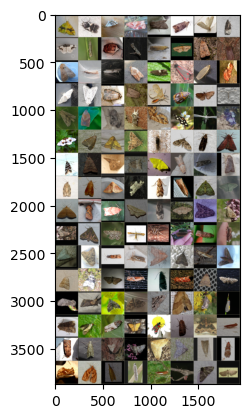

In [16]:
# Sanity check
nr_of_images = batch_size

def matplotlib_imshow(img):   
    invTrans = transforms.Compose([
        transforms.Normalize((0.0, 0.0, 0.0), (1/stds[0], 1/stds[1], 1/stds[2])),
        transforms.Normalize((-means[0], -means[1], -means[2]), (1.0, 1.0, 1.0))
    ])
    img = invTrans(img)  # un-normalise
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_data_loader)
images, labels = next(dataiter)
images = images[:nr_of_images]
labels = labels[:nr_of_images]
img_grid = make_grid(images)
matplotlib_imshow(img_grid)
print('  '.join(
    list(class_mapping.keys())[list(class_mapping.values())
                               .index(labels[j])] if labels[j] > 0 or len(classes_to_trim) == 0 else 'Onbekend' for j in range(nr_of_images)))
plt.show()


## Initialiseer het model

In plaats van een compleet model te trainen, is het efficiënter om een al bestaand model te 'finetunen'. Het maakt niet zo zeer uit waarop het originele model, zoals EfficientNet, getrained is. Het idee is dat het bepaalde patronen en structuren in afbeeldingen kan herkennen, en deze 'kennis' toepast op de foto's uit jouw domein.

In [17]:
model = get_model(model_name, weights='DEFAULT')


De laatse laag van het model wordt vervangen met een lege, nieuwe laag, die het aantal klassen waarop je het model wilt trainen representeert.

In [18]:
nr_in = model.classifier[1].in_features
nr_out = len(set(class_mapping.values()))
model.classifier[1] = torch.nn.Linear(nr_in, nr_out)


Vervolgens wordt het model naar de GPU verplaatst (indien van toepassing).

In [19]:
model.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Nu worden een paar essentiële onderdelen van het model gespecificeerd:
- **Loss function**: Met deze functie berekend het model hoe goed de voorspellingen zijn die het maakt. Het is in feite de afstand tussen de perfecte output, en de werkelijke output. De *loss* is hoog als het model iets voorspelt dat helemaal niet op de perfecte output lijkt.
- **Optimizer**: Functie waarmee het model bepaalt hoe de interne parameters (*weights*) geüpdatet moeten worden.
- **Scheduler**: Functie die beschrijft hoe groot de update stappen van de optimizer moeten zijn.

In [20]:
# Loss function
class_weights = torch.ones(nr_out)
if len(classes_to_trim) > 0:
    class_weights[0] = other_class_weight
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.004)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=eta_max, weight_decay=weight_decay)

# Scheduler
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                              eta_min,
                                              eta_max,
                                              step_size_up=1,
                                              step_size_down=len(train_data_loader)-1,
                                              mode='exp_range',
                                              gamma=gamma,
                                              cycle_momentum=False)


## Functies voor tijdens het trainen

In [21]:
def dict2mdtable(d, key='Name', val='Value'):
    rows = [f'| {key} | {val} |']
    rows += ['|--|--|']
    rows += [f'| {k} | {v} |' for k, v in d.items()]
    return "  \n".join(rows)

def dict2mdtablereport(d):
    rows = [f'| Label | Precision | Recall | F1 | Support |']
    rows += ['|--|--|--|--|--|']
    for k, v in d.items():
        try:
            rows += [f"| {k} | {v['precision']} | {v['recall']} | {v['f1-score']} | {v['support']} |"]
        except Exception as e:
            rows += [f"| {k} | {v} |  |  |  |"]
    return "\n".join(rows)

def validate(data_loader=None, return_results=False):
    running_loss = 0.
    outputs_array = []
    labels_array = []
    
    if data_loader == None:
        data_loader = val_data_loader

    for i, data in enumerate(data_loader):
        inputs, labels = data
        inputs_gpu = inputs.to(device, non_blocking=True)
        labels_gpu = labels.to(device, non_blocking=True)
        outputs_gpu = model(inputs_gpu).detach()
        loss = loss_fn(outputs_gpu, labels_gpu)
        running_loss += loss.detach()
        outputs_array.extend(torch.argmax(outputs_gpu, dim=1).tolist())
        labels_array.extend(labels_gpu.tolist())
        
    avg_loss = running_loss / (i+1)
    precision = precision_score(labels_array, outputs_array, average='weighted', zero_division=0.0)
    recall = recall_score(labels_array, outputs_array, average='weighted', zero_division=0.0)

    if return_results:
        return avg_loss, precision, recall, outputs_array, labels_array
    else:
        return avg_loss, precision, recall

def train_one_epoch(epoch_index, tb_writer, run_validate=True):
    running_loss = 0.
    last_loss = 0.
    t0 = time.time()
    iters = len(train_data_loader)
    
    for i, data in enumerate(train_data_loader):
        print('\r', 'Batch', i, 'out of', iters, end='')
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.detach().item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            tb_x = epoch_index*len(train_data_loader) + i + 1
            if not run_validate:
                tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
            # Run validation set:
            if run_validate:
                model.train(False)
                avg_vloss, precision, recall = validate()
                model.train(True)
                print(f'valid loss: {avg_vloss} precision: {precision} recall: {recall}')
                writer.add_scalars('Precision vs. Recall (train)',
                                   {'Precision': precision, 'Recall': recall},
                                   tb_x)
                writer.add_scalars('Training vs. Validation Loss (train)',
                                   {'Training': last_loss, 'Validation': avg_vloss},
                                   tb_x)
            t0 = time.time()
    print('\n')
    return last_loss


## Trainen

Eerst wat code om de resultaten naar tensorboard te sturen. [Hier is een tutorial om de resultaten van Tensorboard te bekijken](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html#run-tensorboard). Als het klopt is het al geïnstalleerd. Draai dit stukje code **altijd** opnieuw wanneer je een nieuwe trainingssessie start! Anders klopt de representatie in TensorBoard niet meer.

In [22]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/{model_name}/moths_trainer_{timestamp}')
writer.add_text('Hyperparams', dict2mdtable(hparam_dict), 1)
epoch_number = 0


In het volgende blok code wordt het model getraind. Afhankelijk van de dataset, hardware en het aantal epochs (`EPOCHS`, verander deze waarde gerust) moet kan het lang (uren, dagen) duren. Probeer het daarom eerst met een kleine dataset. De voortgang wordt eronder geprint, of is te volgens in TensorBoard.
Elke epoch wordt alle trainingsdata 1 keer door het model gehaald. Aan het einde van elke epoch wordt het resulterende model opgeslagen, als de prestatie van het model verbeterd is t.o.v. de vorige epoch.

In [ ]:
EPOCHS = 20

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch + 1}')
    
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, run_validate=False)

    model.train(False)
    avg_vloss, precision, recall = validate()
    print(f'LOSS train {avg_loss} valid {avg_vloss} (precision: {precision} recall: {recall})')
    writer.add_scalars('Precision vs. Recall',
                       {'Precision': precision, 'Recall': recall},
                       epoch_number + 1)
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()
    
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1


EPOCH 1
 Batch 6486 out of 6487

LOSS train 1.2039302035570145 valid 0.9742080569267273 (precision: 0.8174601800744083 recall: 0.8208201649579897)
EPOCH 2
 Batch 6486 out of 6487



## Testen
Zodra het model klaar is met trainen, kan je het evalueren door de prestatie van het model op de testset te bepalen.

### Als het nodig is: laad het model in
Dit is alleen maar nodig als je een model dat eerder getrained is wilt testen.

In [ ]:
# model = get_model(model_name, weights='DEFAULT')
# model.classifier[1] = torch.nn.Linear(nr_in, nr_out)
# model.to(device)
# model_path = 'naam van bestand'
# model.load_state_dict(torch.load(model_path))


Hieronder wordt de testdata door het model heengehaald. De resultaten worden naar TensorBoard geschreven en eronder geprint.
- **Loss**: hoe lager, hoe beter.
- **Precision**: True positives / (True positives + False negatives), 0 <= precision <= 1
- **Recall**: True positives / (True positives + False positives), 0 <= recall <= 1

[Hier](https://www.evidentlyai.com/classification-metrics/multi-class-metrics) is meer informatie over precision en recall te vinden. 

In [ ]:
model.train(False)
test_loss, test_precision, test_recall, y_pred, y_true = validate(test_data_loader, True)
print(f'Test scores: loss {test_loss} (precision: {test_precision} recall: {test_recall})')
writer.add_scalars('Precision vs. Recall (test)',
                   {'Precision': test_precision, 'Recall': test_recall},
                   1)
writer.add_scalars('Test Loss',
                   {'Test': test_loss},
                   1)
writer.flush()


### Classificatie rapport
Bereken de prestatie van het model per klasse. Sla de resultaten op in TensorBoard.


In [ ]:
labels = []
target_names = []
for label in range(nr_out):
    labels.append(label)
    if label == 0 and len(classes_to_trim) > 0:
        target_name = 'Other'
    else:
        target_name = [i for i in class_mapping if class_mapping[i]==label][0]
    target_names.append(target_name)


In [ ]:
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names, zero_division=0.0))
report_dict = classification_report(y_true, y_pred, labels=labels, target_names=target_names, zero_division=0.0, output_dict=True)
writer.add_text('Test scores', dict2mdtablereport(report_dict), 1)
writer.flush()


## Einde
Als het hele Notebook gerund is, dan is het model getraind en getest. Alle resultaten zijn te vinden in TensorBoard (http://localhost:6006/, als TensorBoard opgestart is). Resultaten van verschillende runs kunnen daar vergeleken worden.